### Playoff Data Historical Stats <img src="playoffs.jpeg" style="height:100px" align = 'right' />

We're looking at historical NBA playoff series data, on a period by period level. I will go through how I pull the data using python's [nba_api](https://github.com/swar/nba_api) package. We will look at data from seasons `1996-97` through `2024-25`.

In [1]:
import nba_api.stats.endpoints as nba
import pandas as pd
import time
from nba_api.stats.static import teams

Using the parameter `period_nullable`, we can pull period by period data.

In [2]:
def PERIOD_DATA(season,loc=None,measure_type='Base'):
	R1 = nba.TeamGameLogs(season_nullable=season,location_nullable = loc,measure_type_player_game_logs_nullable=measure_type,season_type_nullable = "Playoffs",period_nullable=1).get_data_frames()[0]
	R2 = nba.TeamGameLogs(season_nullable=season,location_nullable = loc,measure_type_player_game_logs_nullable=measure_type,season_type_nullable = "Playoffs",period_nullable=2).get_data_frames()[0]
	R3 = nba.TeamGameLogs(season_nullable=season,location_nullable = loc,measure_type_player_game_logs_nullable=measure_type,season_type_nullable = "Playoffs",period_nullable=3).get_data_frames()[0]
	R4 = nba.TeamGameLogs(season_nullable=season,location_nullable = loc,measure_type_player_game_logs_nullable=measure_type,season_type_nullable = "Playoffs",period_nullable=4).get_data_frames()[0]
	df1 = R1.loc[:,['SEASON_YEAR','TEAM_ID','TEAM_ABBREVIATION','TEAM_NAME','GAME_DATE','MATCHUP','WL','PTS','PLUS_MINUS','GAME_ID']]
	df1 = df1.rename(columns = {'PTS':'PTS_Q1','PLUS_MINUS':'PM_Q1'})
	df2 = R2.loc[:,['TEAM_ABBREVIATION','PTS','PLUS_MINUS','GAME_ID']]
	df2 = df2.rename(columns = {'PTS':'PTS_Q2','PLUS_MINUS':'PM_Q2'})
	df3 = R3.loc[:,['TEAM_ABBREVIATION','PTS','PLUS_MINUS','GAME_ID']]
	df3 = df3.rename(columns = {'PTS':'PTS_Q3','PLUS_MINUS':'PM_Q3'})
	df4 = R4.loc[:,['TEAM_ABBREVIATION','PTS','PLUS_MINUS','GAME_ID']]
	df4 = df4.rename(columns = {'PTS':'PTS_Q4','PLUS_MINUS':'PM_Q4'})
	df = pd.merge(df1,df2, on = ['GAME_ID','TEAM_ABBREVIATION'])
	df = pd.merge(df,df3, on = ['GAME_ID','TEAM_ABBREVIATION'])
	df = pd.merge(df,df4, on = ['GAME_ID','TEAM_ABBREVIATION'])
	df = df.rename(columns = {"TEAM_ABBREVIATION":"team"})
	return df

In [3]:
seasons = [str(i)+'-'+str(i+1)[2:] for i in range(1996,2025)]
season = seasons[0]
df = PERIOD_DATA(season)
for season in seasons[1:]:
	P = PERIOD_DATA(season)
	df = pd.concat([df,P])
	time.sleep(0.5)


### Wrangling
Now the fun part. Let's create some useful columns. I'll create the following columns:
- `opp` = Opponent Team abbreviation
- `is_home` = **True** if game is at home, **False** if away
- `game_no` = **1** for first game of the series, **2** for the second, etc..
- `round_no` = **1** (first round), **2** (conference semfinals), **3** (conference finals), and **4** (finals)
- `series` - current series standing (e.g. **3-1** if the team is up **3-1** going into the game
- `total_games` = the total number of games the series went (e.g. **7** if it went all the way, **4** if a team was swept)
- `has_home_court` = **True** for the lower seeded team, **False** for the higher seeded team.


In [4]:
df['is_home'] = P['MATCHUP'].str.contains("vs.")
df = df.rename(columns = {"SEASON_YEAR":"season",'GAME_DATE':"date"})
df['opp'] = df['MATCHUP'].apply(lambda x: x.split(' ')[-1])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values("date")

To create the `game_no` column, I need to groupby `season`,`team` and `series_matchup`. First, I create a `series_matchup` to get a unique identifier for each series.


In [5]:
def get_matchup(s):
    S = s.split(' ')
    S = sorted([S[0],S[-1]])
    return S[0]+'-'+S[1]
df['series_matchup'] = df['MATCHUP'].apply(get_matchup)

# Create the game_no column
df['counter'] = 1
df['game_no'] = df.groupby(['season','team','series_matchup'])['counter'].cumsum()
df = df.drop(columns = ['counter'])

Now to create the `series` column, I first create `series_wins` and `series_losses` columns. Then I will concatenate the two joined by a *-* in between.

In [6]:
# get the current number of series wins
df['win'] = 0
df.loc[df['WL']=='W','win'] = 1
df['series_wins'] = df.groupby(['season','team','series_matchup'])['win'].transform(lambda x: x.cumsum().shift().fillna(0))
df['series_wins'] = df['series_wins'].astype(int)

#get the current number of series losses
df['loss'] = 0
df.loc[df['WL']=='L','loss'] = 1
df['series_losses'] = df.groupby(['season','team','series_matchup'])['loss'].transform(lambda x: x.cumsum().shift().fillna(0))
df['series_losses'] = df['series_losses'].astype(int)



# create a 'series' column (represents what the series is at going into the game)
def do_series(s):
    w,l = s['series_wins'],s['series_losses']
    return str(w)+'-'+str(l)
df['series'] = df.apply(do_series,axis = 1)

In [7]:
df = df.reset_index(drop=True)

In [8]:
df.loc[:,['season','date','team','opp','is_home','series','WL']].set_index('season').tail(5)

,date,team,opp,is_home,series,WL
season,,,,,,
2024-25,2025-04-29,BOS,ORL,True,3-1,W
2024-25,2025-04-29,LAC,DEN,False,2-2,L
2024-25,2025-04-29,MIL,IND,False,1-3,L
2024-25,2025-04-29,IND,MIL,True,3-1,W
2024-25,2025-04-29,ORL,BOS,False,1-3,L


As you can see above, the last rows in our data are up-to-date: the **Celtics** just beat the **Magic** last night (Apr 29, 2025). They went into the game up **3-1**. Meanwhile, the **Clippers** went into **Denver** tied **2-2** and lost.

In [9]:
# Create a 'round_no' column (1 = first round, 2 = second round, 3 = third round, 4 = fourth round)
opps = df.groupby(['season','team'])['opp'].unique()
def do(s):
    season,team,opp = s['season'],s['team'],s['opp']
    k = (season,team)
    l = opps.loc[k].tolist()
    return l.index(opp)+1
df['round_no'] = df.apply(do,axis = 1)

# get the total number of games
totals = df.groupby(['season','team','series_matchup']).size()
def do(s):
    season,team,matchup = s['season'],s['team'],s['series_matchup']
    k = (season,team,matchup)
    return totals.loc[k]
df['total_games'] = df.apply(do,axis = 1)	
	


# Create the 'has_home_court' in series column
X = df.groupby(['season','team','series_matchup']).first()['is_home']
X = X.reset_index()
X = X.rename(columns = {'is_home':'has_home_court'})
df = pd.merge(df,X, on = ['season','team','series_matchup'], how = 'left')

### Crunching some numbers
Let's look at how teams fare when they are up **3-1** in the series.

In [10]:
FILTER = df['series'] == '3-1'
df.loc[FILTER,['date','team','opp','is_home','WL','win','series']].set_index('date').tail()

,team,opp,is_home,WL,win,series
date,,,,,,
2024-05-30,DAL,MIN,True,W,1,3-1
2024-06-17,BOS,DAL,True,W,1,3-1
2025-04-29,NYK,DET,True,L,0,3-1
2025-04-29,BOS,ORL,True,W,1,3-1
2025-04-29,IND,MIL,True,W,1,3-1


In four out of the last five times a team was up **3-1**, they closed out the series. Let's now calculate *how often* this occurs.

In [11]:
df.loc[FILTER]['WL'].value_counts()

W    106
L     64
Name: WL, dtype: int64

In [12]:
df.loc[FILTER]['win'].mean()

0.6235294117647059

Teams up 3-1 win *60*% of the time.

In [13]:
df.loc[FILTER].groupby(['is_home'])['WL'].value_counts()

is_home  WL
False    W     22
         L     15
True     W     31
         L     17
Name: WL, dtype: int64

In [14]:
df.loc[FILTER].groupby(['has_home_court','is_home'])['win'].mean()

has_home_court  is_home
False           False      0.692308
                True       0.758621
True            False      0.363636
                True       0.473684
Name: win, dtype: float64

In [15]:
df.loc[FILTER].groupby(['is_home'])['win'].mean()

is_home
False    0.594595
True     0.645833
Name: win, dtype: float64

In [16]:
FILTER2 = (df['series'] == '3-1') & (~df['is_home'].astype(bool))

In [17]:
df.loc[FILTER2,['date','team','opp','round_no','game_no','series','is_home','WL']].set_index('date')

,team,opp,round_no,game_no,series,is_home,WL
date,,,,,,,
1997-05-12,UTA,LAL,2,5,3-1,False,W
1997-05-14,NYK,MIA,2,5,3-1,False,L
1998-05-12,UTA,SAS,2,5,3-1,False,W
1998-05-13,CHI,CHH,2,5,3-1,False,W
1999-06-25,SAS,NYK,4,5,3-1,False,W
2000-05-15,IND,PHI,2,5,3-1,False,L
2000-05-16,LAL,PHX,2,5,3-1,False,W
2001-06-15,LAL,PHI,4,5,3-1,False,W
2002-05-14,LAL,SAS,2,5,3-1,False,W


In [18]:
df.loc[FILTER]['round_no'].value_counts()

1    88
2    45
3    22
4    15
Name: round_no, dtype: int64

It is interesting to see that fifteen out of the lsat 28 NBA Finals have had a team leading **3-1**. 

In [19]:
FILTER = (df['series']=='3-1')&(df['round_no'] == 4)
df.loc[FILTER,['date','team','opp','round_no','series','WL']].set_index('date')

,team,opp,round_no,series,WL
date,,,,,
1998-06-12,CHI,UTA,4,3-1,L
1999-06-25,SAS,NYK,4,3-1,W
2000-06-16,LAL,IND,4,3-1,L
2001-06-15,LAL,PHI,4,3-1,W
2004-06-15,DET,LAL,4,3-1,W
2008-06-15,BOS,LAL,4,3-1,L
2009-06-14,LAL,ORL,4,3-1,W
2012-06-21,MIA,OKC,4,3-1,W
2014-06-15,SAS,MIA,4,3-1,W


When I was eight years old, I watched Michael Jordan's [infamous push-off](https://www.youtube.com/watch?v=Iu6hmjaIr40) game winner in game 6 of the 1998 Finals. What I see here is that the Jazz had won the game prior. As an avid NBA fan since I was a child, I can recall most of these games. Boston won the championship last year, winning by eighteen points in game 5. Denver did the same the year prior, winning in 5 against teh heat. The warriors in 2019 pushed the series to 6, only to lose that one at home.

## How else can I use the data?

Let's looks at quarter-by-quarter point totals and see how those change by round number, game number, and season.

In [20]:
BY_ROUND = df.groupby(['round_no'])[['PTS_Q1','PTS_Q2','PTS_Q3','PTS_Q4']].mean()
BY_ROUND.apply(lambda x: round(x,2))

,PTS_Q1,PTS_Q2,PTS_Q3,PTS_Q4
round_no,,,,
1,24.83,24.68,24.56,24.41
2,24.59,24.74,24.37,24.16
3,24.49,24.83,24.36,24.42
4,24.15,24.10,24.11,23.87


In [21]:
BY_GAME = df.groupby(['game_no'])[['PTS_Q1','PTS_Q2','PTS_Q3','PTS_Q4']].mean()
BY_GAME.apply(lambda x: round(x,2))

,PTS_Q1,PTS_Q2,PTS_Q3,PTS_Q4
game_no,,,,
1,24.75,24.87,24.46,24.19
2,24.81,25.17,24.63,24.23
3,24.67,24.61,24.20,24.53
4,24.65,24.69,24.59,24.11
5,24.80,24.63,24.47,24.52
6,24.58,23.78,24.52,24.32
7,23.24,23.81,23.74,24.30


The highest scoring quarter is the second quarter of a game 2.

In [22]:
BY_SEASON = df.groupby(['season'])[['PTS_Q1','PTS_Q2','PTS_Q3','PTS_Q4']].mean()

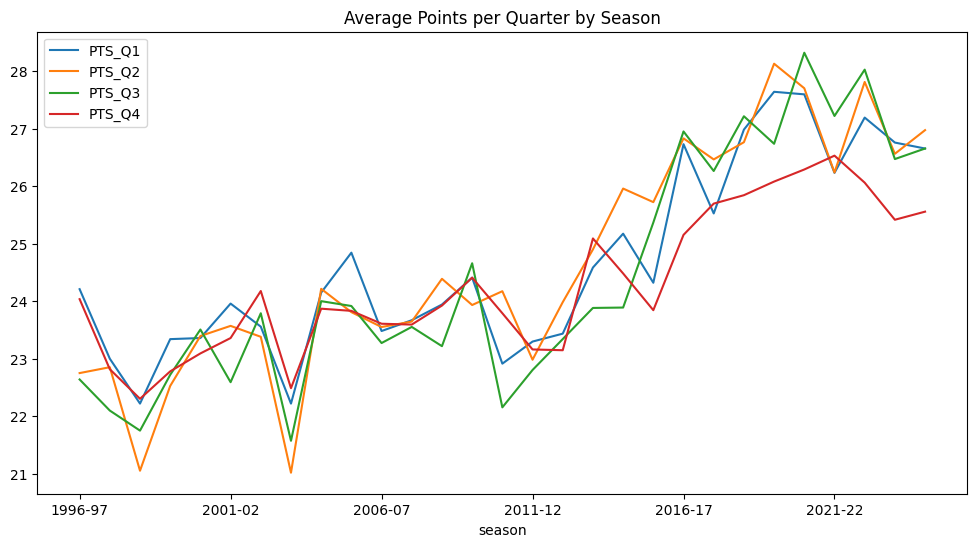

In [23]:
PLOT = BY_SEASON.plot(figsize=(12, 6), title='Average Points per Quarter by Season')

Ok, so points are going up season by season. We also see a dip in fourth quarter points compared to the other quarters. This can be due to defnse tightening up when the game is on the line. Now, let's look at games 5 only. We will group by what the series is at (either 2-2, 3-1, or 1-3). Let's see 

In [24]:
GAME_5 = df[df['game_no'] == 5]
GROUPED = GAME_5.groupby(['is_home','series'])[['PTS_Q1','PTS_Q2','PTS_Q3','PTS_Q4']].mean()

In [25]:
GROUPED.apply(lambda x: round(x,2))

PTS_Q1  PTS_Q2  PTS_Q3  PTS_Q4
is_home series                                
False   1-3      25.08   24.48   24.35   23.45
        2-2      24.77   23.54   23.40   23.10
        3-1      23.19   26.70   22.78   24.65
True    1-3      25.24   24.16   23.98   24.78
        2-2      24.31   24.13   24.53   25.25
        3-1      25.90   26.33   24.88   25.52

Point totals are lower for teams in a series tied `2-2`. They are highest for home teams that are up `3-1`.